# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
import scipy.stats as stats
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy import fftpack
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

import warnings
warnings.filterwarnings('ignore')

cuda


### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

# Functions

In [3]:
def get_param_stats(h5_path, param_ind=0):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_val = sorted(list(h5d.keys()), key=lambda x: float(x))[1]
         
        h5_data = h5d[param_val]
        avg_clps_time = np.mean(h5_data.attrs['collapse_times'])
        std_clps_time = np.std(h5_data.attrs['collapse_times'])
        rog_avg = np.mean(h5_data.attrs['avg_collapse_rog'])
        rog_std = np.std(h5_data.attrs['avg_collapse_rog'])
        return avg_clps_time , std_clps_time, rog_avg, rog_std 


In [4]:
def save_msd_run_data(run_path, param_str, 
                    ss_ind = 1, end_ind = -1,
                    start_bead = 0, end_bead = None,
                  ):
    # Make analysis directory if it doesn't exist
    anal_path = (run_path / 'analysis')
    anal_path.mkdir(exist_ok=True)


    # Create an hdf5 file
    h5_path = anal_path / 'msd_run_data.h5'
    if h5_path.exists():
        h5_path.unlink()
    h5_file = h5py.File(h5_path, 'w')

    # Add label string as attribute
    h5_file.attrs['param'] = param_str

    sim_path = run_path / 'simulations'
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in sim_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

    
        for i, pd in tqdm(enumerate(param_dirs)):
            msd_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                print(f'No data files found for parameter directory {pd}')
                continue

            for h5_data in sd_h5_data_lst:
                # Get data from seed h5 file
                time_arr = h5_data['time'][ss_ind:end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                          :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                msd  = cps.poly_bead_msd(com_arr, device=device)
                msd_list += [msd.tolist()]

            for h5d in sd_h5_data_lst:
                h5d.close()

            # Make sure the runs are all the same length
            min_length = min([len(_) for _ in msd_list])
            msd_arrs = np.array([_[:min_length] for _ in msd_list])

            # Create dataset
            label = re.split(r'(^[^\d]+)', str(pd.name))[1:][1]
            data_arr = np.hstack((time_arr[:min_length][:,np.newaxis],
                                  msd_arrs.mean(axis=0)[:, np.newaxis],
                                  msd_arrs.std(axis=0)[:, np.newaxis]))
            print(data_arr.shape)
            d_set = h5_file.create_dataset(label, data=data_arr)
            d_set.attrs['seeds'] = msd_arrs.shape[0]

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


In [26]:
def graph_msd_ax(fig, ax, h5_path, 
                ci_bound = .95,
                label_str= '{}',
                show_legend=True,
                send_cut_ind = 2,
                fend_cut_ind = -1,
                          ):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
        log_pvs = np.log10([float(p)+.000001 for p in param_vals]) 
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma_r(log_pvs)

        for i, pv in enumerate(reversed(param_vals)):
            h5_data = h5d[pv]
            time_arr = h5_data[send_cut_ind:fend_cut_ind,0]
            mean_msd_arr = h5_data[send_cut_ind:fend_cut_ind,1]
            std_msd_arr = h5_data[send_cut_ind:fend_cut_ind,2]

            _ = ax.plot(time_arr, mean_msd_arr,
                        color=colors[i], label=label_str.format(pv))
            ci = ((std_msd_arr/np.sqrt(h5_data.attrs['seeds'])) *
                  (np.sqrt(2)*erfinv(ci_bound)))
            _ = ax.fill_between(time_arr, 
                                mean_msd_arr - ci, mean_msd_arr + ci, 
                                color=colors[i], alpha=.25)

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        
        _ = ax.set_ylabel('Mean Squared Displacement\n' + r'$MSD$ ($\mu$m$^2$)')
        _ = ax.set_xlabel(r'Lag time $\tau$ (sec)')
        _ = ax.set_yscale('log')
        _ = ax.set_xscale('log')
        if show_legend:
            _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

In [28]:
def make_single_graph_msd(fig, ax, h5_path, key, color='k', 
                          ci_bound = .95, label_str= '{}',
                            send_cut_ind = 2,
                            fend_cut_ind = -1,
                            show_legend = False
                          ):
    with h5py.File(h5_path, 'r') as h5d:
          h5_data = h5d[key]
          time_arr = h5_data[send_cut_ind:fend_cut_ind,0]
          mean_msd_arr = h5_data[send_cut_ind:fend_cut_ind,1]
          std_msd_arr = h5_data[send_cut_ind:fend_cut_ind,2]

          _ = ax.plot(time_arr, mean_msd_arr,
                      color=color, label=label_str.format(key))
          ci = ((std_msd_arr/np.sqrt(h5_data.attrs['seeds'])) *
                (np.sqrt(2)*erfinv(ci_bound)))
          _ = ax.fill_between(time_arr, 
                              mean_msd_arr - ci, mean_msd_arr + ci, 
                              color=color, alpha=.25)

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        
    _ = ax.set_ylabel('Mean Squared Displacement\n' + r'$MSD$ ($\mu$m$^2$)')
    _ = ax.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    if show_legend:
        _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

# Data

In [12]:
data_dir_list = {
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001",
}


In [7]:
# save_msd_run_data(cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1",
#                   'kod') 

In [8]:
print(data_dir_list)

{PosixPath('/mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1')}


In [13]:
for dd in data_dir_list:
    save_msd_run_data(dd, 'kod') 

0it [00:00, ?it/s]

(0, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)


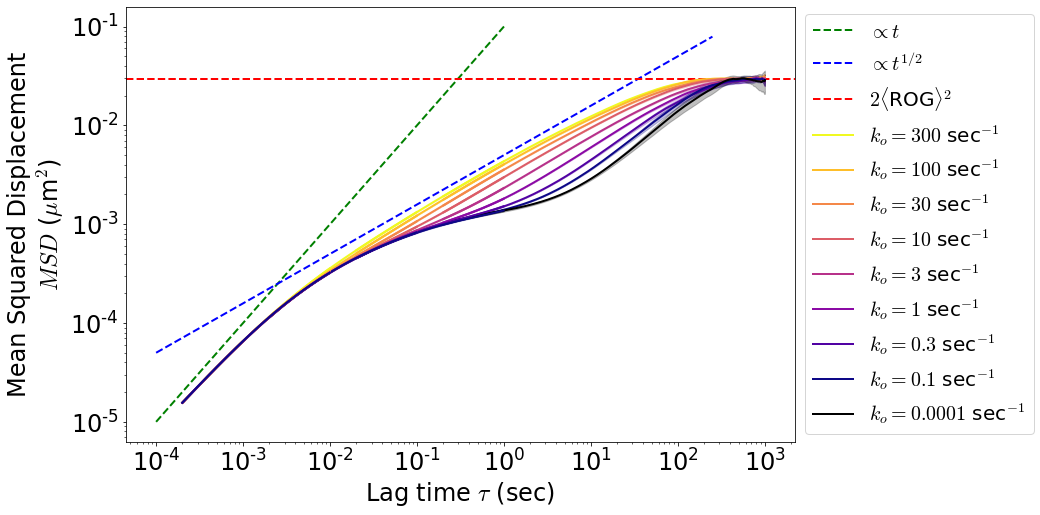

In [30]:
fig, axarr = plt.subplots(1,1, figsize=(12, 8))
# graph_msd_ax(fig, axarr, 
#              cond_path /"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/msd_run_data.h5", 
#              label_str="$k_o = ${}")
# Straight lines
time_arr = np.linspace(.0001, 1000, 2000)
_ = axarr.plot(time_arr[:3], .1*time_arr[:3], c='g', linestyle='--', label= "$\propto t$")
_ = axarr.plot(time_arr[:500], .005*np.sqrt(time_arr[:500]), c='b', linestyle='--', label= "$\propto t^{1/2}$")
# _ = axarr.plot(time_arr[2:350], .0004*np.power(time_arr[2:350],.6), c='g', linestyle='--', label= "$\propto t^{3/5}$")
# _ = axarr.plot(time_arr[:300], .001*np.power(time_arr[:300],.25), c='m', linestyle='--', label= "$\propto t^{1/4}$")
_, _, avg_rog, _ = get_param_stats(cond_path/"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/rog_run_data.h5")
_ = axarr.axhline(2*(avg_rog)**2, .0001, 1000, c='r', linestyle='--', label=r'$2\langle$ROG$\rangle^2$')


graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$")

make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$",show_legend=True) 

make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 

graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, send_cut_ind = 2, fend_cut_ind = -9900)
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, fend_cut_ind = -9900)
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, fend_cut_ind = -9900)

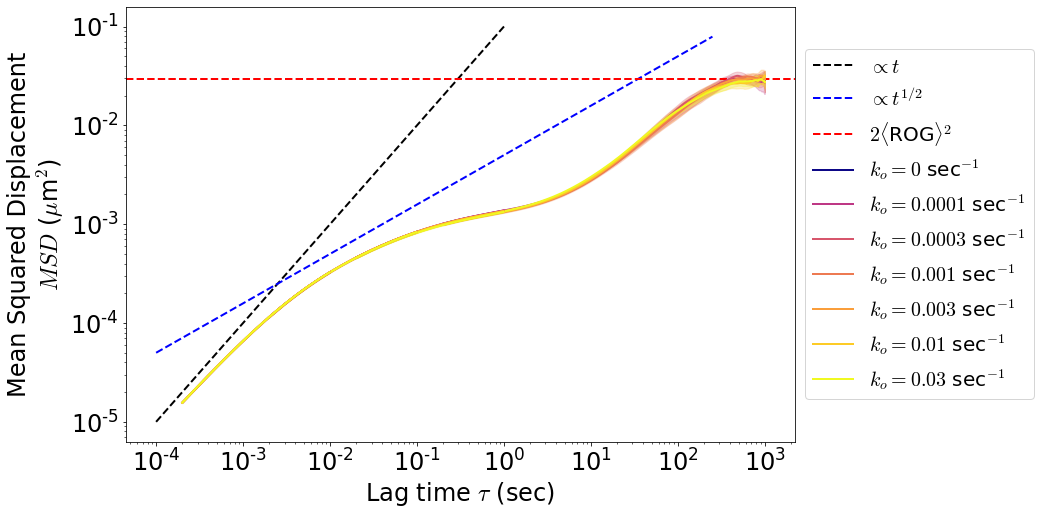

In [23]:
fig, axarr = plt.subplots(1,1, figsize=(12, 8))
# graph_msd_ax(fig, axarr, 
#              cond_path /"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/msd_run_data.h5", 
#              label_str="$k_o = ${}")
# Straight lines
time_arr = np.linspace(.0001, 1000, 2000)
_ = axarr.plot(time_arr[:3], .1*time_arr[:3], c='k', linestyle='--', label= "$\propto t$")
_ = axarr.plot(time_arr[:500], .005*np.sqrt(time_arr[:500]), c='b', linestyle='--', label= "$\propto t^{1/2}$")
_, _, avg_rog, _ = get_param_stats(cond_path/"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/rog_run_data.h5")
_ = axarr.axhline(2*(avg_rog)**2, .0001, 1000, c='r', linestyle='--', label=r'$2\langle$ROG$\rangle^2$')

graph_msd_ax(fig, axarr, 
             cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1/analysis/msd_run_data.h5",
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=True)
graph_msd_ax(fig, axarr, 
             cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01/analysis/msd_run_data.h5",
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, fend_cut_ind = -9900)
graph_msd_ax(fig, axarr, 
             cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001/analysis/msd_run_data.h5",
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, fend_cut_ind = -9900)
graph_msd_ax(fig, axarr, 
             cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001/analysis/msd_run_data.h5",
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, fend_cut_ind = -9900)

# Graphing

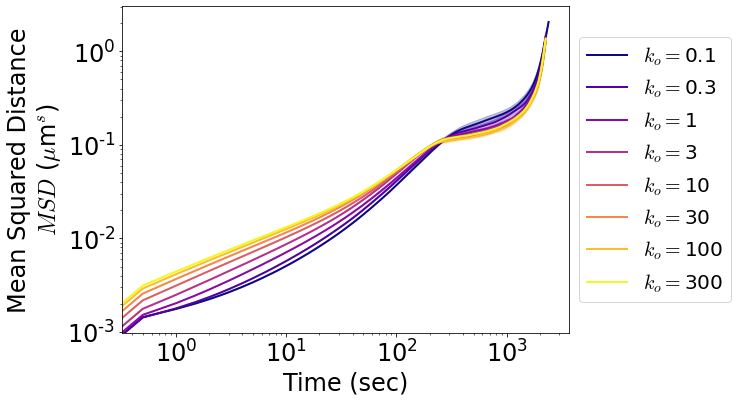

In [20]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_msd_ax(fig, axarr, 
             cond_path /"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/msd_run_data.h5", 
             label_str="$k_o = ${}")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


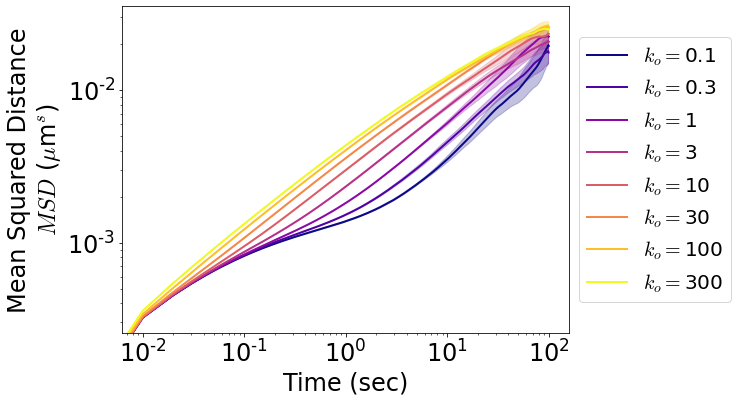

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/msd_run_data.h5", 
             label_str="$k_o = ${}")

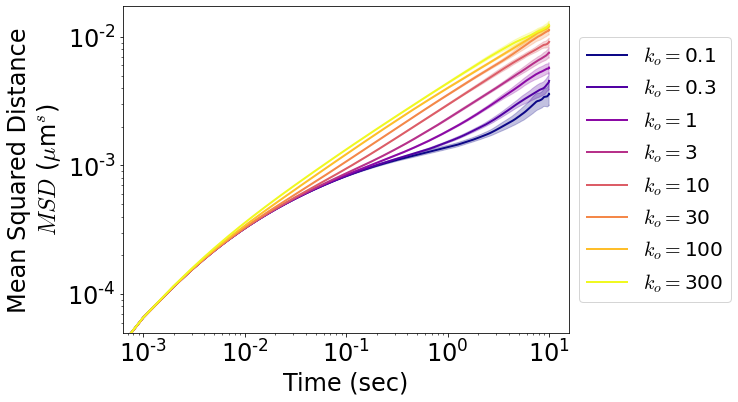

In [18]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/msd_run_data.h5", 
             label_str="$k_o = ${}")

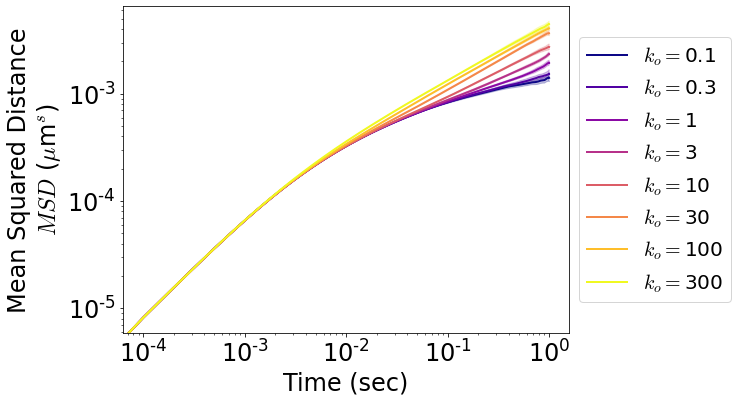

In [19]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/msd_run_data.h5", 
             label_str="$k_o = ${}")

# Figures